Get the difference between nucleus and TFS set of words. See if the words in this set are reasonable. They should be reasonable for when TFS is looser and should not be when TFS is tighter. Out of this set of words, take the highest, lowest prob ones and the middle one? Need at least 3 word gap between them. 
Rank each one in how reasonable it is. Control baseline is how reasonable words at different points in the body are. The first word, half way and at the closer of the tails. Can also get words outside of the last tail, just outside, halfway to the end, and at the very end. 
There are 9 different words in total. Should i rank all of them, scramble up a subset? Or have a ranking for each of the subsets differently? Probably scramble them all up. And then present 3 of them??
Can then see overall how replaceable different parts of the distributions is, and for TFS and nucleus specifically. Have a control with the bad words. And should be able to hopefully show that the difference in replaceability between the TFS and nucleus words is small when TFS is looser and large when TFS is tighter. Can see how specific this is also. Eg could just look at the last TFS and nucleus words, see the diff in replaceability, or maybe need to look at the averages. Look most at this unique subset and these three points should hopefully categorize it. Want them because i dont know how good the signal is going to be. For the closest words for example. 
Can also get overall data on how replaceability corresponds to model probability. 


In [1]:
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd    
import torch

In [2]:
from decodeLogits import *

In [3]:
#updated
vals_dict = {'tfs':[0.25, 0.75, 0.9, 0.95, 0.99],
'n': [0.5, 0.63, 0.69, 0.81, 0.75, 0.9], 'k':[1,40,200]  }


''' {'tfs':[0.25, 0.75, 0.9, 0.95, 0.99], 'flat':[0.01, 0.02, 0.05],
'n': [0.1, 0.25, 0.5, 0.63, 0.69, 0.75, 0.81, 0.9], 'k':[1,10,40,200]  }'''

" {'tfs':[0.25, 0.75, 0.9, 0.95, 0.99], 'flat':[0.01, 0.02, 0.05],\n'n': [0.1, 0.25, 0.5, 0.63, 0.69, 0.75, 0.81, 0.9], 'k':[1,10,40,200]  }"

# Doing analysis for the same logit going to use the ground truth as it is a Schelling point

In [4]:
from importlib import reload
import utils

reload(utils)
from utils import *

In [5]:
batch_size=25
num_batches=4
prompt_length=100
generated_length=150
tot_len = prompt_length+generated_length

import encoder
model_name='774M' #345M
models_dir='../gpt-2/models'
enc = encoder.get_encoder(model_name, models_dir)

prompts=pd.read_csv('test_dataframe_500primer.csv')

In [6]:
gpt_out_path = 'gpt-2_output/'
additional_path = '-model_774M-seed_27'#'' 
#all_perps = pickle.load( gzip.open(gpt_out_path+'all_perplexities_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv'+additional_path+'.pickle.gz', 'rb'))
all_logits = pickle.load( gzip.open(gpt_out_path+'all_logits_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv'+additional_path+'.pickle.gz', 'rb')) # needed to get the probabilities
text = pickle.load( gzip.open(gpt_out_path+'all_text_perplexity_scores_for_the_dataset_Human_StoryPrompts_Completion.csv'+additional_path+'.pickle.gz', 'rb'))

In [7]:
tot_num = 0
mapping_to_batch = dict()
for i in range(num_batches):
    num_in_batch = all_logits[i].shape[0]
    for el, b_ind in zip(range(tot_num, tot_num+num_in_batch), range(0, num_in_batch)):
        mapping_to_batch[el] = (i, b_ind) # actual batch and then the ind in that batch
    print( num_in_batch)
    tot_num+= num_in_batch
tot_num

23
23
24
22


92

In [8]:
all_logits[0].shape

(23, 150, 50257)

# Want to generate things that are at the different probability levels

# Looking at max deviation and getting these points within the tails of each

## Want to also focus on the maximum deviation portions at some point. 

In [9]:
np.random.seed(28)

In [10]:
# random prompts and locations within the 150 generation locations

num_prompts_and_timepoints_wanted = 50 # cant be larger than 100 right now!!!
assert num_prompts_and_timepoints_wanted <=100
leading_prompt = 15

want_min_max = False

if want_min_max==True:
    minmax = pd.read_csv('Min_Max_Disagreement_Coords_TFS90.csv')
    #shuffle it and take the number that is wanted. 
    minmax = minmax.sample(frac= num_prompts_and_timepoints_wanted/minmax.shape[0])
    display(minmax.head())
    
else:
    rand_prompts = np.random.randint(0,tot_num, num_prompts_and_timepoints_wanted)
    # leadingprompt until 150. as the logits are 150 not 250. 
    # -1 because of the end token prediction
    rand_times = np.random.randint(0,generated_length-1, num_prompts_and_timepoints_wanted)

In [11]:
len(all_logits[0][0, :, 0])

150

getting random locations
for the differnet gen strategies. find the tail locations. take the tokens at each position. 
move onto the next random location. 

In [12]:
from importlib import reload
import utils

reload(utils)
from utils import *

In [32]:
enc = encoder.get_encoder(model_name, models_dir)

In [38]:
lol = text[batch_ind][ind_in_batch][text_timepoint]
print(lol)
gword = decoder_text([lol])
print(gword)
c = enc.encode(gword.strip())
print(c)
decoder_text(c)

356
 we
[732]


'we'

In [13]:
# applying all analyses to the logits. 
prompt_length = 100
slices_from_each = 6 # as one will also be the ground truth word. 
to_df = []

# randomly select generations and positions in those generations. from the original prompts. 
for r_ind in range(0, num_prompts_and_timepoints_wanted):
    
    if want_min_max ==True:
        prompt = 999
        batch_ind, ind_in_batch = minmax.iloc[r_ind, 1], minmax.iloc[r_ind, 2]
        time_point = minmax.iloc[r_ind,3]
        if time_point>=149:
            continue # because of the stop token being predicted. 
        text_timepoint = time_point+prompt_length+1 # +1 because the perplexities keeps the end prediction token. 
    else:
        prompt = rand_prompts[r_ind]
        time_point = rand_times[r_ind]
        text_timepoint = time_point+prompt_length+1 # +1 because the perplexities keeps the end prediction token. 
        batch_ind, ind_in_batch = mapping_to_batch[prompt]
    
    sps = softmax(-np.sort(-all_logits[batch_ind][ind_in_batch, time_point, :]))
    prob_slices_wanted = np.linspace(sps[0],0,slices_from_each)
    
    indices = np.argsort(-all_logits[batch_ind][ind_in_batch, time_point, :])
    ground_token = text[batch_ind][ind_in_batch][text_timepoint]
    prev_token = text[batch_ind][ind_in_batch][text_timepoint-1]
    prev_prev_token = text[batch_ind][ind_in_batch][text_timepoint-2]
    prev_tokens = [ground_token, prev_token,prev_prev_token]
    
    stripped_prev_tokens = []
    # need to strip the spaces and recode. 
    for t in prev_tokens:
        
        gword = decoder_text([t])
        space_free = enc.encode(gword.strip())
        stripped_prev_tokens.append(space_free)
    
    #print('prev tokens', prev_tokens)
    real_prompt_words, _ = remove_non_words(stripped_prev_tokens, wantPrint=False)
    #print(real_prompt_words)
    if len(real_prompt_words)<len(stripped_prev_tokens):
        print('one of the three tokens in front were not words so skipping')
        continue
    
    ground_word = decoder_text([ground_token])
    # what the ground token is
    ground_word_prob = sps[ground_token]
    
    #get the 15 words in front. 
    lead_prompt_words = decoder_text(text[batch_ind][ind_in_batch][text_timepoint-leading_prompt:text_timepoint])
    df_row = [prompt, time_point, batch_ind, ind_in_batch, lead_prompt_words, ground_word, ground_word_prob] # taking it from the last one. 
    
    print('ten sps values', sps[0:10])
    print('prob slices:', prob_slices_wanted)
    
    #remove any non word tokens from whole list. (could be done more efficiently)
    real_word_tokens, abs_pos = remove_non_words(indices)
    real_word_probs = sps[np.asarray(abs_pos)]
    
    rel_to_abs_index = {rel:absolute for rel, absolute in zip(range(len(abs_pos)), abs_pos )}
    
    # select the right positions and words: 
    #NEED TO IGNORE ANY OF THE SLICES THAT ARE TOO LARGE.  TAKE THE HIGHEST PROB WORD AND THEN DO THE SLICES.
    rel_words_positions_wanted, sel_word_probs = get_specific_positions_from_probs(real_word_probs, prob_slices_wanted)
    
    print('words wanted rel positions', rel_words_positions_wanted)
    
    abs_words_positions_wanted = [ rel_to_abs_index[rel] for rel in rel_words_positions_wanted]
    print(np.asarray(real_word_tokens)[np.asarray(rel_words_positions_wanted)])
    df_row.append(np.asarray(real_word_tokens)[np.asarray(rel_words_positions_wanted)]) # adding the words themselves. 
    df_row.append(abs_words_positions_wanted)
    df_row.append(sel_word_probs)
        
    to_df.append(df_row)

ten sps values [9.7826791e-01 2.1306623e-03 7.7810284e-04 5.0903222e-04 4.9161154e-04
 4.3409874e-04 3.7558551e-04 3.6901754e-04 3.4070396e-04 2.6838572e-04]
prob slices: [0.97826791 0.78261433 0.58696074 0.39130716 0.19565358 0.        ]
words wanted rel positions [0, 1, 2, 3, 4, 35195]
['events' 'event' 'things' 'circumstances' 'bad' 'Population']
one of the three tokens in front were not words so skipping
ten sps values [0.12378731 0.1110413  0.10720164 0.09488712 0.07680266 0.04294153
 0.03562189 0.01786945 0.01625022 0.01591282]
prob slices: [0.12378731 0.09902984 0.07427238 0.04951492 0.02475746 0.        ]
words wanted rel positions [0, 3, 4, 5, 6, 35194]
['were' 'had' 'would' 'could' 'are' 'iterator']
ten sps values [0.27985963 0.1617055  0.08516163 0.06683456 0.03213869 0.03016647
 0.02423738 0.00844133 0.00640868 0.00623327]
prob slices: [0.27985963 0.22388771 0.16791578 0.11194385 0.05597193 0.        ]
words wanted rel positions [0, 1, 2, 3, 4, 35196]
['edge' 'counter' 'sin

In [14]:
d = enchant.Dict("en_US")
d.check('rust')

True

In [15]:
results = pd.DataFrame(to_df, columns = ['prompt_ind', 'time_point', 
                               'batch_ind', 'ind_in_batch', 'leading_words',
                               'ground_word', 'ground_word_prob', 'words', 'abs_inds', 'probs'])
                                         
results

prompt_ind  time_point  batch_ind  ind_in_batch  \
0           19          28          0            19   
1           72         100          3             2   
2           31          29          1             8   
3           56          73          2            10   
4           24          60          1             1   
5           13          64          0            13   
6           42         108          1            19   
7           62          53          2            16   
8           31          28          1             8   
9           39          46          1            16   
10          53         100          2             7   
11          33         114          1            10   
12          48          24          2             2   
13          42          45          1            19   
14          19           2          0            19   
15          23          91          1             0   
16          17         144          0            17   
17          23          42          1             0   
18           7         117          0             7   

                                        leading_words   ground_word  \
0    change something, might be the one trigger th...        events   
1    the world ’ s leading pharmaceutical companie...         would   
2    off guard. While your body lay half on the co...          edge   
3     I'm getting rrREAdy''. My murmur had ended with             a   
4    crunched underneath and the ground bubbled wi...         creek   
5   lady because the ugly mug of hers somehow brin...            is   
6    before it can even be started. \n \n Neverthe...         adept   
7    voice. ``I wish I could actually be challenge...         shock   
8    you off guard. While your body lay half on th...           the   
9    their data analysis, their legislation and li...         novel   
10  , I fully use the power of organization and am...   secretaries   
11   to use modern aged weapons. Everyone else was...    technology   
12   dude, that was hell you just came from. (I to...          Jews   
13  , despite both parties equally capable of feel...         trade   
14    . Just count the stars, right? * \n \n He eased           his   
15  . Thoughts of her always danced in the back of...           his   
16   \n He had forgotten so much of this day. He h...          told   
17  . One of the most satisfying moments for him w...         smile   
18           expecting it. ” \n \n“ So are you saying            we   

    ground_word_prob                                              words  \
0       4.103564e-07  [events, event, things, circumstances, bad, Po...   
1       5.513494e-05           [were, had, would, could, are, iterator]   
2       1.622044e-06           [edge, counter, sink, side, table, Plot]   
3       5.716932e-05                  [a, the, my, an, me, conservancy]   
4       2.153896e-08                     [and, of, oak, sand, sky, Eat]   
5       2.049686e-04               [he, is, makes, she, the, prototype]   
6       1.260401e-08       [simple, a, young, deliberate, simply, 7601]   
7       2.355514e-06                [his, a, the, thought, an, cumbers]   
8       3.848319e-05                     [your, the, his, it, one, ODE]   
9       1.560937e-05  [social, political, medical, research, design,...   
10      2.166052e-10      [organized, at, in, people, organizers, rush]   
11      3.796790e-06     [the, weapons, these, their, weaponry, Sexual]   
12      2.580503e-06        [same, story, truth, other, whole, cumbers]   
13      1.015331e-05    [own, place, partner, value, chances, Reviewed]   
14      5.129267e-06               [his, himself, the, out, back, CAST]   
15      9.561581e-06                   [him, his, it, the, her, Export]   
16      2.744273e-05                    [so, a, the, too, able, Tokens]   
17      2.294331e-06              [man, new, smile, pillow, lover, DEM]   
18      2.269794e-05                     [that, money, th

In [16]:
assert results.drop_duplicates('leading_words').shape == results.shape

In [17]:
results.shape

(19, 10)

In [18]:
results.head(7)

prompt_ind  time_point  batch_ind  ind_in_batch  \
0          19          28          0            19   
1          72         100          3             2   
2          31          29          1             8   
3          56          73          2            10   
4          24          60          1             1   
5          13          64          0            13   
6          42         108          1            19   

                                       leading_words ground_word  \
0   change something, might be the one trigger th...      events   
1   the world ’ s leading pharmaceutical companie...       would   
2   off guard. While your body lay half on the co...        edge   
3    I'm getting rrREAdy''. My murmur had ended with           a   
4   crunched underneath and the ground bubbled wi...       creek   
5  lady because the ugly mug of hers somehow brin...          is   
6   before it can even be started. \n \n Neverthe...       adept   

   ground_word_prob                                              words  \
0      4.103564e-07  [events, event, things, circumstances, bad, Po...   
1      5.513494e-05           [were, had, would, could, are, iterator]   
2      1.622044e-06           [edge, counter, sink, side, table, Plot]   
3      5.716932e-05                  [a, the, my, an, me, conservancy]   
4      2.153896e-08                     [and, of, oak, sand, sky, Eat]   
5      2.049686e-04               [he, is, makes, she, the, prototype]   
6      1.260401e-08       [simple, a, young, deliberate, simply, 7601]   

                  abs_inds                                              probs  
0   [0, 1, 2, 3, 4, 50158]  [0.9782679, 0.0021306623, 0.00077810284, 0.000...  
1   [0, 3, 5, 6, 7, 50140]  [0.123787306, 0.09488712, 0.04294153, 0.035621...  
2   [0, 1, 2, 3, 4, 50130]  [0.27985963, 0.1617055, 0.08516163, 0.06683456...  
3   [0, 1, 2, 3, 4, 50140]  [0.41619945, 0.17138307, 0.11777301, 0.0551321...  
4   [4, 5, 6, 7, 8, 50156]  [0.023683885, 0.013982991, 0.011684752, 0.0113...  
5   [0, 1, 2, 3, 4, 50158]  [0.22781697, 0.077138565, 0.047752414, 0.04415...  
6  [0, 2, 4, 7, 15, 50152]  [0.042511407, 0.031731628, 0.023607282, 0.0148...

In [19]:
results.loc[5, 'leading_words']

'lady because the ugly mug of hers somehow brings a sense of familiarity that'

In [20]:
results.to_csv('backup_of_different_prob_slices.csv')

In [21]:
file_name_base = 'prob_slice_replaceable_comparisons'

In [28]:
answer_orders = []
with open(file_name_base + '_blind_output.txt', 'w') as file: 
    file.write('For each of the following assignments, rank on a scale of 1-5 how possible each word is, given the provided context. \n')
    file.write('Some words are stems, if the word could be completed then you can still rank it highly. And be generous with acronyms that could be plausible. ')
    file.write('It helps to repeat the last few words of the prompt in your head while deciding how replaceable the current one is.')
    file.write('5 means the word would work very well here, 1 means it doesnt make any sense, 3 means it could potentially work.')
    file.write('===================================================== \n \n')
    for ind in range(results.shape[0]):
        file.write('Prompt '+str(ind)+'. \n')
        file.write('The '+str(leading_prompt)+' words in front: \n \n')
        file.write(results.loc[ind, 'leading_words']+' _______')
        #file.write(results.loc[ind, 'leading_words']+' : '+ results.loc[ind, 'ground_word'] )
        file.write('\n')
        
        words = [results.loc[ind, 'ground_word']]
        words += list(results.loc[ind, 'words'])
        words =np.asarray(words)
        
        order = ['ground_word']
        order += [str(i) for i in range(len(words)-1)]
        order = np.asarray(order)
        
        probs = [results.loc[ind, 'ground_word_prob']]
        probs += results.loc[ind, 'probs']
        probs = np.asarray(probs)
                
        #print(words, order)
        shuffler = np.random.choice(range(len(words)), size =len(words), replace=False )
        #print(len(words))
        #print(shuffler)
        
        words = words[shuffler]
        order = order[shuffler]
        probs = probs[shuffler]
        
        question_answers = []
        for w, p, o in zip(words,probs, order):
            
            if o=='ground_word':
                w_p = (w,p,1)
            else: 
                w_p = (w,p,0)
        
            question_answers.append(w_p)
            
        answer_orders.append(question_answers)
        
        #print('after', words, order)
        
        for i in range(len(words)):
            file.write(str(i+1)+'. '+words[i]+' ')
                
        file.write('\n \n')
        file.write('=====================================================')
        file.write('\n \n')
        
with open(file_name_base + '_answers.txt', 'w') as file: 
    for ind, w_p in enumerate(answer_orders):
        file.write('Prompt '+str(ind)+' : \n')
        for el_ind, el in enumerate(w_p): 
            file.write(str(el_ind+1) + '. '+str(el) +' ')
        file.write('\n')
        file.write('=====================================================')
        file.write('\n')

pickle.dump(answer_orders,open(file_name_base + '_answers_list.pickle','wb'))

In [29]:
answer_orders

[[(' events', 4.1035644926523673e-07, 1),
  ('things', 0.0007781028398312628, 0),
  ('events', 0.9782679080963135, 0),
  ('bad', 0.0004916115431115031, 0),
  ('Population', 7.025027803399253e-13, 0),
  ('circumstances', 0.0005090322229079902, 0),
  ('event', 0.0021306623239070177, 0)],
 [('would', 0.04294152930378914, 0),
  (' would', 5.5134936701506376e-05, 1),
  ('had', 0.09488712251186371, 0),
  ('iterator', 1.5726539862037647e-11, 0),
  ('are', 0.01786944642663002, 0),
  ('were', 0.1237873062491417, 0),
  ('could', 0.03562188893556595, 0)],
 [('side', 0.06683456152677536, 0),
  ('counter', 0.16170549392700195, 0),
  ('Plot', 1.6408815278756705e-11, 0),
  (' edge', 1.6220442375924904e-06, 1),
  ('sink', 0.08516162633895874, 0),
  ('edge', 0.27985963225364685, 0),
  ('table', 0.03213869407773018, 0)],
 [('an', 0.0551321804523468, 0),
  ('me', 0.044027868658304214, 0),
  ('the', 0.1713830679655075, 0),
  ('my', 0.11777301132678986, 0),
  ('conservancy', 2.3627343137544443e-11, 0),
  (

In [24]:
answer_orders

[[('event', 0.0021306623239070177),
  ('things', 0.0007781028398312628),
  ('bad', 0.0004916115431115031),
  (' events', 4.1035644926523673e-07),
  ('circumstances', 0.0005090322229079902),
  ('events', 0.9782679080963135),
  ('Population', 7.025027803399253e-13)],
 [('iterator', 1.5726539862037647e-11),
  (' would', 5.5134936701506376e-05),
  ('would', 0.04294152930378914),
  ('are', 0.01786944642663002),
  ('could', 0.03562188893556595),
  ('had', 0.09488712251186371),
  ('were', 0.1237873062491417)],
 [('sink', 0.08516162633895874),
  ('table', 0.03213869407773018),
  ('Plot', 1.6408815278756705e-11),
  ('counter', 0.16170549392700195),
  ('edge', 0.27985963225364685),
  ('side', 0.06683456152677536),
  (' edge', 1.6220442375924904e-06)],
 [('a', 0.4161994457244873),
  ('the', 0.1713830679655075),
  ('me', 0.044027868658304214),
  (' a', 5.716932355426252e-05),
  ('conservancy', 2.3627343137544443e-11),
  ('an', 0.0551321804523468),
  ('my', 0.11777301132678986)],
 [('and', 0.023683

In [212]:
[[5, 3, 4, 3, 1, 4, 5, 4, 4, 2,], [3,2,5,1,4,5,3,5,2,4],[5,4,1,5, 3,5,4,5,2,2], [3,5,3,5,5,3,4,5,4], [3,5,2,2,3,4,4,1,5,5],[5, 2, 1,5,2,5,4,5,1,4], [1,5,5,4,5,5,5,4,3], [1,1,2,1,1,5,5,5,2,4], [4,1,5,5,4,3,5,3,2,2], [5,2,3,4,5,5,5,5,5,4]]

[[5, 3, 4, 3, 1, 4, 5, 4, 4, 2],
 [3, 2, 5, 1, 4, 5, 3, 5, 2, 4],
 [5, 4, 1, 5, 3, 5, 4, 5, 2, 2],
 [3, 5, 3, 5, 5, 3, 4, 5, 4],
 [3, 5, 2, 2, 3, 4, 4, 1, 5, 5],
 [5, 2, 1, 5, 2, 5, 4, 5, 1, 4],
 [1, 5, 5, 4, 5, 5, 5, 4, 3],
 [1, 1, 2, 1, 1, 5, 5, 5, 2, 4],
 [4, 1, 5, 5, 4, 3, 5, 3, 2, 2],
 [5, 2, 3, 4, 5, 5, 5, 5, 5, 4]]

In [213]:
for r in res: 
    print(len(r))

10
10
10
10
10
10
10
10
10
10


In [214]:
prd = dict()
for ind, (r, a) in enumerate(zip(res, answer_orders)):
    for r_el, a_el in zip(r,a):
        try:
            prd[a_el[1]].append(r_el)
        except:
            prd[a_el[1]] = [r_el]

In [215]:
prd = pd.DataFrame(prd).T

In [216]:
prd.head()

0
1.438798e-02  5
1.133592e-01  1
1.043329e-02  5
4.023387e-06  4
4.646489e-11  5

In [217]:
prd.reset_index(inplace=True)
#prd.drop('index', axis=1, inplace=True)
prd.columns = ['probs', 'rep']
prd.head()

probs  rep
0  1.438798e-02    5
1  1.133592e-01    1
2  1.043329e-02    5
3  4.023387e-06    4
4  4.646489e-11    5

In [218]:
from importlib import reload
import utils

reload(utils)
from utils import *

In [219]:
prd['rep'] = prd['rep']*2

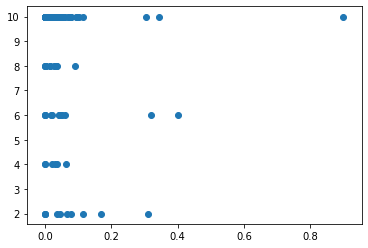

In [220]:
# do a scatter plot of this. 
plt.scatter(prd['probs'], prd['rep'])

In [225]:
means = prd.groupby('rep').mean()
means

probs
rep          
2    0.081718
4    0.025102
6    0.083610
8    0.023622
10   0.054777

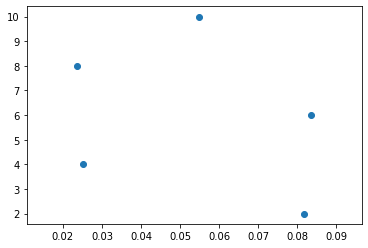

In [226]:
plt.scatter(means['probs'], means.index)

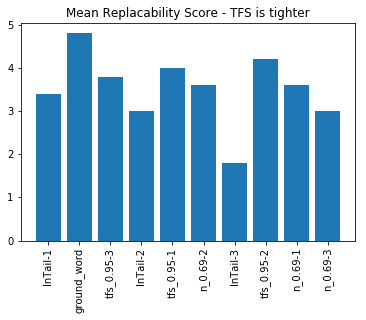

In [276]:
bar_plot_columns(prd, 'TFS is tighter')

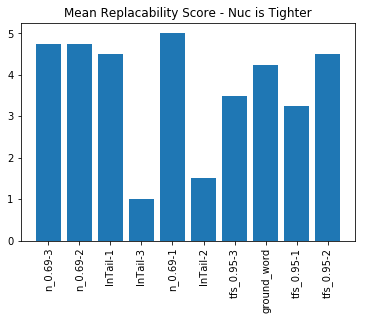

In [279]:
bar_plot_columns(nuc_tighter, 'Nuc is Tighter')

Want when Nuc is tighter for the difference between Nuc and TFS to be smaller than it is when TFS is tighter. 

In [280]:
abs_diff_of_different_locations(tfs_tighter, tfs_label, n_label)

position: 1 = 0.3999999999999999
position: 2 = 0.6000000000000001
position: 3 = 0.7999999999999998


In [281]:
abs_diff_of_different_locations(nuc_tighter,tfs_label, n_label)

position: 1 = 1.75
position: 2 = 0.25
position: 3 = 1.25
